<a href="https://colab.research.google.com/github/beifa/M5_Forecasting/blob/master/v2fork_of_default_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gc
import pickle
import random
import numpy as np
import pandas as pd
import lightgbm as lgb

PATH = '/kaggle/input/wmt-inc/'
PATH_PLUS = '/kaggle/input/wmt-plus/'
PATH_WEIGHT = '/kaggle/input/weight-wmt/' #d --> 1158 - 1914
PATH_MODEL = ''

PATH_D1 = ''
PATH_D2 = ''
PATH_D3 = ''
PATH_D4 = '/kaggle/input/make-lags-pca/'
PATH_D5 = '/kaggle/input/make-trend-prob-sales/'
PATH_D6 = '/kaggle/input/make-trend-prob-sales-v2/'

SEED = 13
random.seed(SEED)
np.random.seed(SEED)
VER = 208

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'bagging_fraction': 0.5,
    'subsample_freq': 1,
    'learning_rate':0.03,
    'num_leaves': 2048,
    'min_data_in_leaf': 4096,
    'feature_fraction': 0.5,
    'max_bin': 100,
    'n_estimators': 1400,
    'boost_from_average': False,
    'verbose': -1
    }

lgb_params['seed'] = SEED

stores = [
#               'CA_1',
#               'CA_2',
#               'CA_3',
#               'CA_4',
#               'TX_1',
#               'TX_2',
               'TX_3',
#               'WI_1',
#               'WI_2',
#               'WI_3'
              ]


def read_data(store, start = 0):
    
    remove_features = ['id','state_id','store_id', 'd','sales'] 
    
    encode_f = [
        'enc_dept_id_mean',
        'enc_item_id_mean',   
        'enc_item_id_state_id_mean',      
        'enc_item_id_store_id_mean'   
        ]#best var, 0.47034
    
    
    ewm = [
        'ewm_lags12_v2',
        #'ewm_lags25_v2'
          ]
    
    df = pd.concat([
                pd.read_pickle(PATH_D1),
                pd.read_pickle(PATH_D1),
                pd.read_pickle(PATH_D1)],
                axis =1)
    df= df[df.store_id == store]    
    gc.collect()
    
    
    lags = pd.read_pickle(PATH_D2)
    lags = lags[lags.index.isin(df.index)]
    df = pd.concat([df, lags], axis=1)
    del lags
    gc.collect()    

    encode = pd.read_pickle(PATH_D3)[encode_f]
    encode = encode[encode.index.isin(df.index)]
    df = pd.concat([df, encode], axis=1)
    del encode
    gc.collect()      
    
    test = pd.read_pickle(PATH_D4 + 'lags_v2.pkl')[ewm]
    test = test[test.index.isin(df.index)]
    df = pd.concat([df, test], axis=1)
    del test
    gc.collect()
    
    #CA
    test = pd.read_pickle('../input/test-pred-wmt/predict_steps_ca.pkl')['pred_CA_1']
    test = test[test.index.isin(df.index)]
    df = pd.concat([df, test], axis=1)
    del test
    gc.collect()
    
    test = pd.read_pickle('../input/predict-clf-make-v2-ca-3/predict_steps_ca_2.pkl')['pred_CA_2']
    test = test[test.index.isin(df.index)]
    df = pd.concat([df, test], axis=1)
    del test
    gc.collect()
    
    test = pd.read_pickle('../input/predict-clf-make-v2-ca3/predict_steps_ca_3.pkl')['pred_CA_3']
    test = test[test.index.isin(df.index)]
    df = pd.concat([df, test], axis=1)
    del test
    gc.collect()
    
    test = pd.read_pickle('../input/predict-clf-make-v2-ca4/predict_steps_ca_4.pkl')['pred_CA_4']
    test = test[test.index.isin(df.index)]
    df = pd.concat([df, test], axis=1)
    del test
    gc.collect()
    
    #WI
    test = pd.read_pickle('../input/test-pred-wmt/predict_steps_wi.pkl')['pred_WI_1']
    test = test[test.index.isin(df.index)]
    df = pd.concat([df, test], axis=1)
    del test
    gc.collect()
        
    test = pd.read_pickle('../input/predict-clf-make-v2-wi-2/predict_steps_wi_2.pkl')['pred_WI_2']
    test = test[test.index.isin(df.index)]
    df = pd.concat([df, test], axis=1)
    del test
    gc.collect()
    
    test = pd.read_pickle('../input/test-pred-wmt/predict_steps_wi_3.pkl')['pred_WI_3']
    test = test[test.index.isin(df.index)]
    df = pd.concat([df, test], axis=1)
    del test
    gc.collect()    
    
    #TX    
    test = pd.read_pickle('../input/test-pred-wmt/predict_steps_tx.pkl')['pred_TX_1']
    test = test[test.index.isin(df.index)]
    df = pd.concat([df, test], axis=1)
    del test
    gc.collect()
    
    test = pd.read_pickle('../input/predict-clf-make-v2-tx-2/predict_steps_tx_2.pkl')['pred_TX_2']
    test = test[test.index.isin(df.index)]
    df = pd.concat([df, test], axis=1)
    del test
    gc.collect()
    
    test = pd.read_pickle('../input/predict-clf-make-v2-tx-3/predict_steps_tx_3.pkl')['pred_TX_3']
    test = test[test.index.isin(df.index)]
    df = pd.concat([df, test], axis=1)
    del test
    gc.collect() 
    
    
    df['pred_diff_ca_wi'] = (
        df['pred_CA_1'] - df['pred_CA_2'] - df['pred_CA_3'] - df['pred_CA_4']\
        - df['pred_WI_1'] - df['pred_WI_2'] - df['pred_WI_3'] 
    )
    
    df = df.drop([
        'pred_CA_1',
        'pred_CA_2',
        'pred_CA_3',
        'pred_CA_4',
        'pred_TX_1',
        'pred_TX_2',
        'pred_TX_3',
        'pred_WI_1',
        'pred_WI_2',
        'pred_WI_3'                 
                 ], axis = 1)
    
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d','sales']+features]
    
    #skip row
    df = df[df.d >= start].reset_index(drop=True)
    return df, features

In [ ]:
# ############ Calculations function #############
# # We will define a function outside of the custom 
# # metric. This is because the custom function only 
# # has two inputs: preds and train_data, and we need 
# # to incorporate more than that to make it flexible. 

def L12_WRMSSE(preds, actuals, p_horizon, num_products, scale, weight): 
  
  actuals = actuals[-(p_horizon * num_products):]
  preds = preds[-(p_horizon * num_products):]
  diff = actuals - preds

  # The first step in calculating the wrmsse is 
  # squareing the daily error.
  res = diff ** 2

  # Now divide the result by the appropriate scale
  # take values of scale to avoid converting res 
  # to a pandas series
  res = res/scale.values

  # The next step is summing accross the horizon
  # We must reshape our data to get the products
  # in line. 
  res = res#.values
  res = res.reshape(p_horizon, num_products)

  # Now we take the mean accross the prediction horizon
  # and take the square root of the result.
  res = res.mean(axis=0)
  res = np.sqrt(res)

  # Now we multiply each result with the appropriate
  # scaled_weight. We just need the first 30490 entries 
  # of the scaled_weight column
  res = res * weight
  res = res.sum()
  return res

def get_weights_scales_level_12(df, end_test, path):  
    wdf = pd.read_csv(f'{path}weight_scale_{end_test-27}.csv')
    wdf['scaled_weight'] = wdf.weight/np.sqrt(wdf.scale)
    wdf = wdf[wdf.Level_id == 'Level12']
    wdf['id'] = wdf['Agg_Level_1'] + '_' +  wdf['Agg_Level_2'] + '_validation' #Total_X_validation
    wdf = wdf[['id', 'scale', 'weight', 'scaled_weight']]
    wdf = pd.merge(df[['id']], wdf, on='id', how='left')
    return wdf

    ################### Custom metric #####################
def custom_metric(preds, train_data):    
    actuals = train_data.get_label()    
    res = L12_WRMSSE(preds, actuals, P_HORIZON, NUM_PRODUCTS, scale, weight)
    return 'L12_WRMSSE', res, False

Start train lgbm


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's rmse: 2.19659	valid_1's rmse: 1.68974
[200]	training's rmse: 2.1082	valid_1's rmse: 1.67708
[300]	training's rmse: 2.07943	valid_1's rmse: 1.66748
[400]	training's rmse: 2.06082	valid_1's rmse: 1.66063
[500]	training's rmse: 2.04508	valid_1's rmse: 1.65357
[600]	training's rmse: 2.03116	valid_1's rmse: 1.64798
[700]	training's rmse: 2.01874	valid_1's rmse: 1.64395
[800]	training's rmse: 2.00787	valid_1's rmse: 1.63971
[900]	training's rmse: 1.99715	valid_1's rmse: 1.6358
[1000]	training's rmse: 1.98735	valid_1's rmse: 1.63163
[1100]	training's rmse: 1.97834	valid_1's rmse: 1.62722
[1200]	training's rmse: 1.96932	valid_1's rmse: 1.62349
[1300]	training's rmse: 1.9615	valid_1's rmse: 1.61997
[1400]	training's rmse: 1.95375	valid_1's rmse: 1.61578
Ends


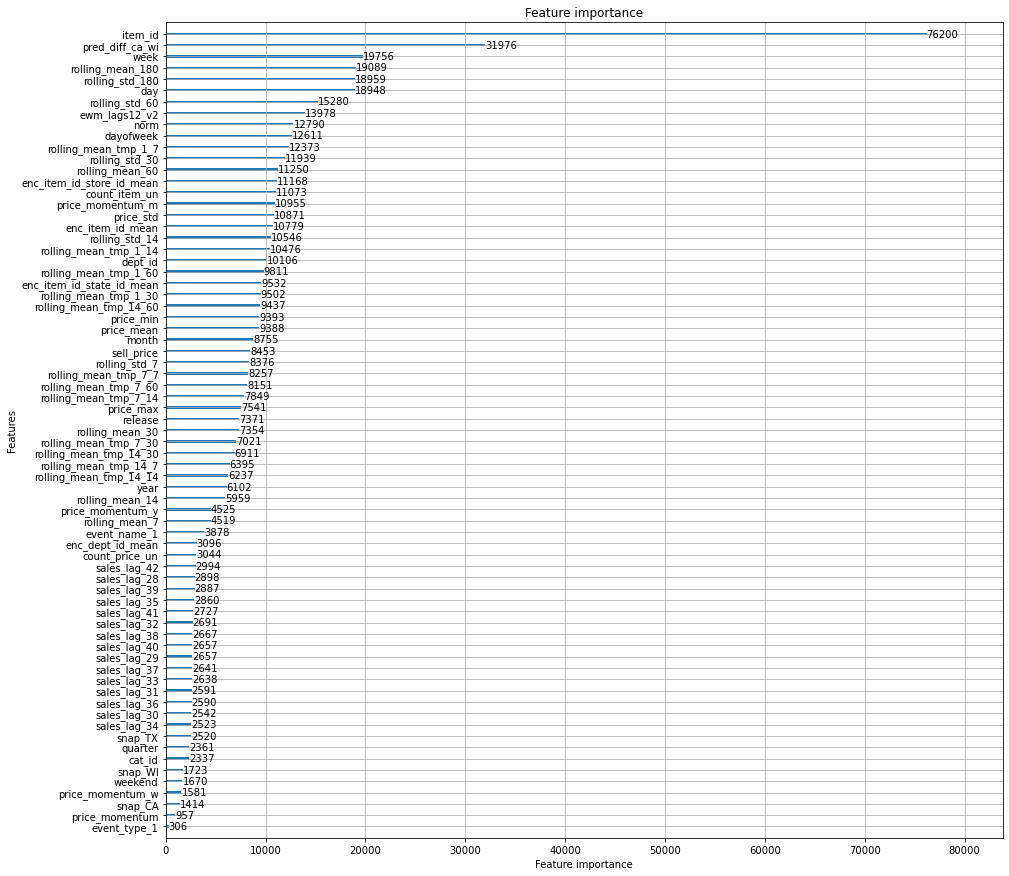

In [ ]:
for store in stores:
    
    df, features = read_data(store, start = 0)    
    #mask
    tr_mask = df.d <= 1913
    va_mask = (df.d <= 1913) & (df.d > (1913-28))
    pred_mask = df.d > (1913 - 100)    
    
    ##metric
    
    #for our custom metric to work.
    #tr_va_mask = tr_mask & (df['d']>(1913-56))     
    
#     wdf = get_weights_scales_level_12(df, 1913, PATH_WEIGHT)    
#     NUM_PRODUCTS = df.id.nunique()   # Number of products 
#     scale = wdf[tr_va_mask].scale
#     weight = wdf[tr_va_mask].weight[:NUM_PRODUCTS]
#     # Normalize weights so that the sum to 1.
#     weight = weight/weight.sum()
    
    
    train_data = lgb.Dataset(df[tr_mask][features], 
                            label=df[tr_mask]['sales'])
    train_data.save_binary('train_data.bin')
    train_data = lgb.Dataset('train_data.bin')
    val_data = lgb.Dataset(df[va_mask][features], 
                          label=df[va_mask]['sales'])

    #make test data and save
    df = df[pred_mask].reset_index(drop=True) #1913-100   
    keep_cols = [col for col in list(df) if '_tmp_' not in col]   
    df = df[keep_cols]
    df.to_pickle('test_'+store+'.pkl')
    del df
    gc.collect()    
    
    print('Start train lgbm')
    estimator = lgb.train(lgb_params,
                            train_data,
                            valid_sets = [train_data, val_data],
                            verbose_eval = 100,                        
                           
                            )
    lgb.plot_importance(estimator, figsize=(15,15))
    #save model
    model_name = 'lgb_model_'+store+'_v'+str(VER)+'.bin'
    pickle.dump(estimator, open(model_name, 'wb')) 
    !rm train_data.bin
    del train_data, val_data, estimator
    gc.collect()
    print('Ends')